In [76]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import itertools
import pandas_ta

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow_probability import distributions as tfd
import tensorflow_probability as tfp
from sklearn.preprocessing import StandardScaler
import yfinance as yf

In [97]:
# spy_ohlc_df = yf.download('SPY', start='1999-02-01', end='2019-12-01')
# spy_ohlc_df = yf.download('SPY', start='2019-01-01', end='2023-12-01')
spy_ohlc_df = yf.download('MSFT', start='2019-01-01', end='2023-12-01')
df = spy_ohlc_df

[*********************100%***********************]  1 of 1 completed


In [98]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Open,1137.0,2.247413e+02,6.629224e+01,9.955000e+01,1.628200e+02,2.354300e+02,2.789300e+02,3.513200e+02
High,1137.0,2.271387e+02,6.694959e+01,1.001900e+02,1.647800e+02,2.385500e+02,2.824600e+02,3.514700e+02
Low,1137.0,2.223162e+02,6.559729e+01,9.720000e+01,1.612600e+02,2.327300e+02,2.762200e+02,3.422000e+02
Close,1137.0,2.248547e+02,6.630371e+01,9.740000e+01,1.631800e+02,2.357700e+02,2.793200e+02,3.481000e+02
Adj Close,1137.0,2.208714e+02,6.712711e+01,9.287469e+01,1.578992e+02,2.323327e+02,2.758100e+02,3.481000e+02
Volume,1137.0,2.986418e+07,1.244557e+07,8.989200e+06,2.229770e+07,2.682380e+07,3.364660e+07,9.701270e+07


In [99]:
spy_ohlc_df['1d_close_pct'] = spy_ohlc_df['Close'].pct_change(1)
spy_ohlc_df['2d_close_pct'] = spy_ohlc_df['Close'].pct_change(2)
spy_ohlc_df['3d_close_pct'] = spy_ohlc_df['Close'].pct_change(3)
spy_ohlc_df['4d_close_pct'] = spy_ohlc_df['Close'].pct_change(4)
spy_ohlc_df['5d_close_pct'] = spy_ohlc_df['Close'].pct_change(5)
spy_ohlc_df['10d_close_pct'] = spy_ohlc_df['Close'].pct_change(10)
spy_ohlc_df['5d_future_close'] = spy_ohlc_df['Close'].shift(-1)
spy_ohlc_df['5d_future_close_pct'] = spy_ohlc_df['5d_future_close'].pct_change(5)

In [100]:
spy_ohlc_df['10d_volatility'] = spy_ohlc_df['Close'].rolling(window=10).std()
tr_df = pd.DataFrame()
tr_df['High-Low'] = spy_ohlc_df['High'] - spy_ohlc_df['Low']
tr_df['High-ClosePrev'] = abs(spy_ohlc_df['High'] - spy_ohlc_df['Close'].shift(1))
tr_df['Low-ClosePrev'] = abs(spy_ohlc_df['Low'] - spy_ohlc_df['Close'].shift(1))
spy_ohlc_df['TR'] = tr_df[['High-Low', 'High-ClosePrev', 'Low-ClosePrev']].max(axis=1)
spy_ohlc_df['ATR10'] = spy_ohlc_df['TR'].rolling(window=10).mean()
spy_ohlc_df['WATR'] = spy_ohlc_df['TR'].rolling(window=14).apply(lambda x: np.average(x, weights=np.arange(1, 14 + 1))) # Weighted Average True Range (WATR)

In [101]:
spy_ohlc_df['SMA20'] = spy_ohlc_df.Close.rolling(20).mean()
spy_ohlc_df['EMA20'] = spy_ohlc_df.Close.ewm(span=20).mean()
spy_ohlc_df['SMA50'] = spy_ohlc_df.Close.rolling(50).mean()
spy_ohlc_df['EMA50'] = spy_ohlc_df.Close.ewm(span=50).mean()
spy_ohlc_df['SMA100'] = spy_ohlc_df.Close.rolling(100).mean()
spy_ohlc_df['EMA100'] = spy_ohlc_df.Close.ewm(span=100).mean()

spy_ohlc_df['RSI_14'] = pandas_ta.rsi(spy_ohlc_df['Close'],length=14)
spy_ohlc_df['RSI_100'] = pandas_ta.rsi(spy_ohlc_df['Close'],length=100)

vor_df = pandas_ta.vortex(spy_ohlc_df['High'],spy_ohlc_df['Low'],spy_ohlc_df['Close'],14)
spy_ohlc_df['VTXP_14'] = vor_df['VTXP_14']
spy_ohlc_df['VTXM_14'] = vor_df['VTXM_14']
stoch_df = pandas_ta.stoch(spy_ohlc_df['High'],spy_ohlc_df['Low'],spy_ohlc_df['Close'],k=14,d=26)
spy_ohlc_df['STOCHk_14_26_3'] = stoch_df['STOCHk_14_26_3']
spy_ohlc_df['STOCHd_14_26_3'] = stoch_df['STOCHd_14_26_3']
adx_df = pandas_ta.adx(spy_ohlc_df['High'],spy_ohlc_df['Low'],spy_ohlc_df['Close'],length=14)#average directional index
spy_ohlc_df['ADX_14'] = adx_df['ADX_14']
spy_ohlc_df['DMP_14'] = adx_df['DMP_14']
spy_ohlc_df['DMN_14'] = adx_df['DMN_14']
amat_df = pandas_ta.amat(spy_ohlc_df['Close']) #Archer Moving Averages Trends
spy_ohlc_df['AMATe_LR_8_21_2'] = amat_df['AMATe_LR_8_21_2']
spy_ohlc_df['AMATe_SR_8_21_2'] = amat_df['AMATe_SR_8_21_2']
aroon_df = pandas_ta.aroon(spy_ohlc_df['High'],spy_ohlc_df['Low']) #Aroon & Aroon Oscillator
spy_ohlc_df['AROOND_14'] = aroon_df['AROOND_14']
spy_ohlc_df['AROONU_14'] = aroon_df['AROONU_14']
spy_ohlc_df['AROONOSC_14'] = aroon_df['AROONOSC_14']
psar_df = pandas_ta.psar(spy_ohlc_df['High'],spy_ohlc_df['Low'],spy_ohlc_df['Close']) #Parabolic Stop and Reverse
# spy_ohlc_df['PSARl_0.02_0.2'] = psar_df['PSARl_0.02_0.2']
# spy_ohlc_df['PSARs_0.02_0.2'] = psar_df['PSARs_0.02_0.2']
spy_ohlc_df['PSARaf_0.02_0.2'] = psar_df['PSARaf_0.02_0.2']
spy_ohlc_df['PSARr_0.02_0.2'] = psar_df['PSARr_0.02_0.2']
ao_df = pandas_ta.ao(spy_ohlc_df['High'],spy_ohlc_df['Low'])#Awesome Oscillator
spy_ohlc_df['AO_5_34'] = ao_df
uo_df = pandas_ta.uo(spy_ohlc_df['High'],spy_ohlc_df['Low'],spy_ohlc_df['Close'])#Ultimate Oscillator
spy_ohlc_df['UO_7_14_28'] = uo_df
cg_df = pandas_ta.cg(spy_ohlc_df['Close'])#Center of Gravity
spy_ohlc_df['CG_10'] = cg_df
coppock_df = pandas_ta.coppock(spy_ohlc_df['Close'])#Coppock
spy_ohlc_df['COPC_11_14_10'] = coppock_df
inertia_df = pandas_ta.inertia(spy_ohlc_df['Close'],spy_ohlc_df['High'],spy_ohlc_df['Low'])#inertia
spy_ohlc_df['INERTIA_20_14'] = inertia_df
stc_df = pandas_ta.stc(spy_ohlc_df['Close']) #schaff trend cycle
spy_ohlc_df['STC_10_12_26_0.5'] = stc_df['STC_10_12_26_0.5']
spy_ohlc_df['STCmacd_10_12_26_0.5'] = stc_df['STCmacd_10_12_26_0.5']
spy_ohlc_df['STCstoch_10_12_26_0.5'] = stc_df['STCstoch_10_12_26_0.5']
tsi_df = pandas_ta.tsi(spy_ohlc_df['Close']) # true strength index
spy_ohlc_df['TSI_13_25_13'] = tsi_df['TSI_13_25_13']
qstick_df = pandas_ta.qstick(spy_ohlc_df['Open'],spy_ohlc_df['Close']) #q stick indicator
spy_ohlc_df['QS_10'] = qstick_df
vhf_df = pandas_ta.vhf(spy_ohlc_df['Close'])#vertical horizontal filter
spy_ohlc_df['VHF_28'] = vhf_df
dpo_df = pandas_ta.dpo(spy_ohlc_df['Close']) #detrend price oscillator
spy_ohlc_df['DPO_20'] = dpo_df
pdist_df = pandas_ta.pdist(spy_ohlc_df['Open'],spy_ohlc_df['High'],spy_ohlc_df['Low'],spy_ohlc_df['Close'])
spy_ohlc_df['PDIST'] = pdist_df
rvi_df = pandas_ta.rvi(spy_ohlc_df['Close'],spy_ohlc_df['High'],spy_ohlc_df['Low']) #relative volatility index
spy_ohlc_df['RVI_14'] = rvi_df
willr_df = pandas_ta.willr(spy_ohlc_df['High'],spy_ohlc_df['Low'],spy_ohlc_df['Close']) # William's Percent R (WILLR)
spy_ohlc_df['WILLR_14'] = willr_df
ebsw_df = pandas_ta.ebsw(spy_ohlc_df['Close']) #Even Better SineWave (EBSW)
spy_ohlc_df['EBSW_40_10'] = ebsw_df
kurt_df = pandas_ta.kurtosis(spy_ohlc_df['Close']) #kurtosis
spy_ohlc_df['KURT_30'] = kurt_df
zscore_df = pandas_ta.zscore(spy_ohlc_df['Close'])
spy_ohlc_df['ZS_30'] = zscore_df
chop_df = pandas_ta.chop(spy_ohlc_df['High'],spy_ohlc_df['Low'],spy_ohlc_df['Close']) #choppiness index
spy_ohlc_df['CHOP_14_1_100'] = chop_df

In [102]:
print(spy_ohlc_df.shape)
spy_ohlc_df = spy_ohlc_df.dropna()
print(spy_ohlc_df.shape)

(1137, 59)
(1026, 59)


In [103]:
train_dataset = spy_ohlc_df.sample(frac=0.8,random_state=0)
test_dataset = spy_ohlc_df.drop(train_dataset.index)
train_dataset = train_dataset.drop('5d_future_close', axis=1)
test_dataset = test_dataset.drop('5d_future_close', axis=1)

train_labels = train_dataset.pop('5d_future_close_pct')
test_labels = test_dataset.pop('5d_future_close_pct')


In [104]:
scaler = StandardScaler()
normed_train_data = pd.DataFrame(scaler.fit_transform(train_dataset), columns=train_dataset.columns)
normed_test_data = pd.DataFrame(scaler.fit_transform(test_dataset), columns=test_dataset.columns)

In [105]:
def plot_history(history: tf.keras.callbacks.History) -> None:
    """
    Plot training vs validation MAE and MSE over epoch.
    """
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    f,a = plt.subplots(1,3,figsize=(12,3))
    a[0].plot(hist['epoch'], hist['mae'],label='Train Error')
    a[0].plot(hist['epoch'], hist['val_mae'],label = 'Val Error')
    a[0].set(xlabel='Epoch',ylabel='MAE')
    a[0].legend()

    a[1].plot(hist['epoch'], hist['mse'],label='Train Error')
    a[1].plot(hist['epoch'], hist['val_mse'],label = 'Val Error')
    a[1].set(xlabel='Epoch',ylabel='MSE')
    a[1].legend()

    a[2].plot(hist['epoch'], hist['loss'],label='Train Error')
    a[2].plot(hist['epoch'], hist['val_loss'],label = 'Val Error')
    a[2].set(xlabel='Epoch',ylabel='Loss func.')
    a[2].legend()
    plt.show()

## Model

In [106]:
def posterior_mean_field(kernel_size, bias_size, dtype) -> tf.keras.Model:
    """Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`."""
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    
    return tf.keras.Sequential([tfp.layers.VariableLayer(2 * n, dtype=dtype),
                                tfp.layers.DistributionLambda(lambda t: tfd.Independent(tfd.Normal(loc=t[..., :n],
                                                              scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
                                                              reinterpreted_batch_ndims=1)),])


def prior_trainable(kernel_size, bias_size, dtype) -> tf.keras.Model:
    """Specify the prior over `keras.layers.Dense` `kernel` and `bias`."""
    n = kernel_size + bias_size
    return tf.keras.Sequential([tfp.layers.VariableLayer(n, dtype=dtype),  # Returns a trainable variable of shape n, regardless of input
                                tfp.layers.DistributionLambda(lambda t: tfd.Independent(tfd.Normal(loc=t, scale=1),reinterpreted_batch_ndims=1)),])

In [118]:
def mse_penalty_term(y_true, y_pred):
    # penalty = 1e-5
    # loss = tf.where(tf.less(y_true * y_pred, 0), penalty * abs(y_pred) * tf.square(y_true - y_pred), tf.square(y_true - y_pred))
    penalty = 10.5
    loss = tf.where(tf.less(y_true * y_pred, 0), penalty * tf.square(y_true - y_pred), tf.square(y_true - y_pred))
    return tf.reduce_mean(loss, axis=-1)

def custom_activity_regularizer(weights, alpha=10.0):
    return alpha * tf.reduce_sum(tf.square(weights))

def build_model() -> tf.keras.Model:
    model = keras.Sequential([
        tfp.layers.DenseVariational(64, activation='relu', 
                                    input_shape=[len(train_dataset.keys())], 
                                    make_posterior_fn=posterior_mean_field, 
                                    make_prior_fn=prior_trainable,),

        tfp.layers.DenseVariational(64, activation='relu', 
                                    activity_regularizer=custom_activity_regularizer,
                                    make_posterior_fn=posterior_mean_field, 
                                    make_prior_fn=prior_trainable,),
 
        layers.Dense(24,kernel_regularizer=tf.keras.regularizers.l2(1.0)),
        layers.Dense(1),
        ])

    # optimizer = tf.keras.optimizers.legacy.RMSprop(0.001)
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
    # optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.001,momentum=0.9)

    model.compile(loss=mse_penalty_term,#'mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model

In [119]:
model = build_model()
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_variational_10 (Dens  (None, 64)                11136     
 eVariational)                                                   
                                                                 
 dense_variational_11 (Dens  (None, 64)                12480     
 eVariational)                                                   
                                                                 
 dense_10 (Dense)            (None, 24)                1560      
                                                                 
 dense_11 (Dense)            (None, 1)                 25        
                                                                 
Total params: 25201 (98.44 KB)
Trainable params: 25201 (98.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [120]:
EPOCHS = 100
history = model.fit(
    normed_train_data, 
    train_labels,
    epochs=EPOCHS, 
    validation_split = 0.4, 
    verbose=0,)

In [121]:
hist_df = pd.DataFrame(history.history)
hist_df['epoch'] = history.epoch
hist_df.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
95,16185.706055,0.171431,0.083134,12567.085938,0.148697,0.050240,95
96,12916.826172,0.142244,0.046784,16262.309570,0.140396,0.045683,96
97,15799.979492,0.174251,0.113313,10424.820312,0.141038,0.049335,97
98,15454.168945,0.182355,0.090535,12908.249023,0.170460,0.087300,98
99,14047.781250,0.181235,0.096150,13676.338867,0.163771,0.060413,99


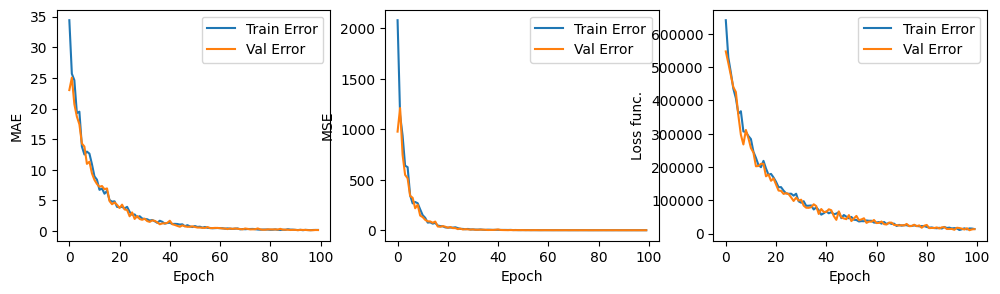

In [122]:
plot_history(history)

In [123]:
loss1, mae1, mse1 = model.evaluate(normed_test_data, test_labels, verbose=2)
print("Testing set Mean Abs Error: {:5.2f}".format(mae1))
train_predictions1 = model.predict(normed_train_data).flatten()
test_predictions1 = model.predict(normed_test_data).flatten()

7/7 - 0s - loss: 14107.0381 - mae: 0.1528 - mse: 0.0481 - 17ms/epoch - 2ms/step
Testing set Mean Abs Error:  0.15
7/7 [==============================] - 0s 585us/step


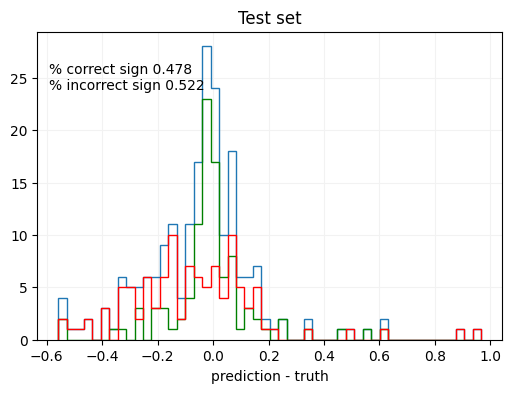

In [124]:
residuals = np.array(test_predictions1) - np.array(test_labels)
same_sign_indices = np.where(np.sign(test_predictions1) == np.sign(test_labels))
diff_sign_indices = np.where(np.sign(test_predictions1) != np.sign(test_labels))

plt.figure(figsize=(6,4))
_, bins, _ = plt.hist(residuals,bins=50,histtype='step')
plt.hist(residuals[same_sign_indices],bins=bins,histtype='step',color='green')
plt.hist(residuals[diff_sign_indices],bins=bins,histtype='step',color='red')
plt.grid(color='0.95')
plt.xlabel('prediction - truth')
plt.title('Test set')
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
text_x = x_min + 0.025 * (x_max - x_min)
text_y = y_max - 0.1 * (y_max - y_min)
plt.text(text_x, text_y, '% correct sign {:.3f}\n% incorrect sign {:.3f}'.format(len(residuals[same_sign_indices])/len(residuals),
                                                                                 len(residuals[diff_sign_indices])/len(residuals)), ha='left', va='top')
plt.savefig('bnn-sign-hist.png')
plt.show()

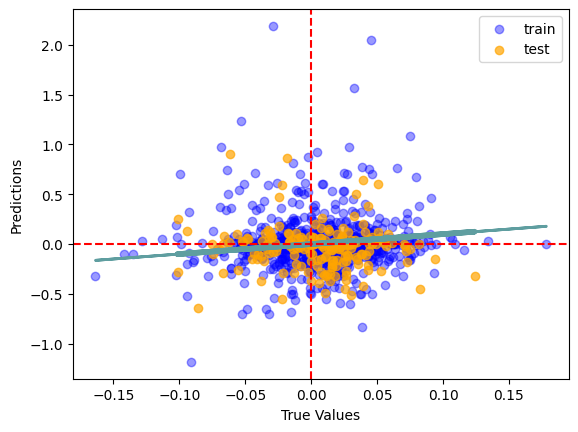

In [125]:
a = plt.axes()
plt.scatter(train_labels, train_predictions1,color='blue',label='train',alpha=.4)
plt.scatter(test_labels, test_predictions1,color='orange',label='test',alpha=.7)
plt.plot(test_labels, test_labels,lw=4,color='cadetblue')
plt.plot(train_labels, train_labels,lw=2,color='cadetblue')
plt.axhline(y=0,ls='--',color='red')
plt.axvline(x=0,ls='--',color='red')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.legend()
plt.savefig('bnn-scatter.png')
plt.show()

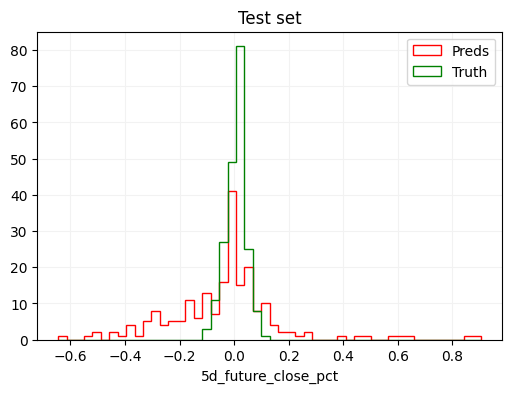

In [126]:
plt.figure(figsize=(6,4))
_, bins, _ = plt.hist(test_predictions1,bins=50,histtype='step',color='red',label='Preds')
plt.hist(test_labels,bins=bins,histtype='step',color='green',label='Truth')
plt.grid(color='0.95')
plt.xlabel('5d_future_close_pct')
plt.title('Test set')
plt.legend()
# plt.savefig('bnn-pred-hist.png')
plt.show()

In [127]:
# plt.figure(figsize=(3,2))
# plt.hist2d(test_labels, test_predictions1, bins=20, cmap='Blues')
# plt.axhline(y=0,ls='--',color='red')
# plt.axvline(x=0,ls='--',color='red')
# plt.xlabel('Truth')
# plt.ylabel('Predictions')
# plt.title('Test Predictions')
# plt.colorbar()
# plt.show()

In [62]:
test_predictions1 = model.predict(normed_test_data).flatten()
# print(test_predictions1[:15])
# print(test_labels[:15])
# normed_test_data['yhat'] = test_predictions1
# normed_test_data.head()

7/7 [==============================] - 0s 726us/step
[ 0.03010701  0.00139172 -0.00074925 -0.00198962 -0.02157785 -0.02766158
  0.00773786  0.02064691  0.01908992  0.0147606  -0.00744416  0.04349492
  0.03525697  0.02219723  0.02942656]
Date
2019-06-12    0.004126
2019-06-24   -0.009808
2019-06-28    0.009079
2019-07-02    0.007995
2019-07-08    0.001247
2019-07-12    0.000333
2019-07-18   -0.005555
2019-07-25    0.006700
2019-07-26   -0.001821
2019-07-29   -0.002455
2019-08-02   -0.030073
2019-08-12    0.015552
2019-08-16    0.012048
2019-08-19   -0.007663
2019-09-09   -0.000235
Name: 1d_future_close_pct, dtype: float64


In [116]:
# Use a list comprehension to predict over each test instance 100 times.
yhats = [model.predict(normed_test_data).flatten() for _ in range(100)]

1/7 [===>..........................] - ETA: 0s

7/7 [==============================] - 0s 5ms/step


In [2]:
import matplotlib
fig, ax = plt.subplots(figsize=(12,5))
scat_xs, scat_ys = [], []
viol_xs, viol_ys = [], []
n=3
for i in np.arange(n,n+5):
    viol_ys.append(np.array(yhats)[:, i])
    scat_xs.append(normed_test_data.index.values[i])
    scat_ys.append(test_labels.values[i])
    viol_xs.append(normed_test_data.index.values[i])

ax.scatter(scat_xs, scat_ys,color='green',label='Truth')
violin = ax.violinplot(viol_ys,positions=viol_xs,showmeans=True,showmedians=True)
for pc in violin["bodies"]:
    pc.set(facecolor="grey",edgecolor="black",alpha=0.3)

violin['cbars'].set(ec='black',lw=0.5,alpha=0.7)
violin['cmins'].set(ec='red',lw=0.5,alpha=0.5)
violin['cmaxes'].set(ec='red',lw=0.5,alpha=0.5)
violin['cmeans'].set(ec='black',lw=1)
ax.tick_params(axis='x', rotation=45)
ax.set(xlabel='Date',ylabel='3d_future_close_pct')
ax.grid(color="0.95")
legend_elements = [matplotlib.lines.Line2D([0], [0], marker='o', label='Truth',markerfacecolor='g', markersize=10,linestyle='None'),
                   matplotlib.patches.Patch(facecolor='grey', edgecolor='k',label='Models dist.')]

ax.legend(handles=legend_elements,loc='best')
plt.show()

NameError: name 'plt' is not defined

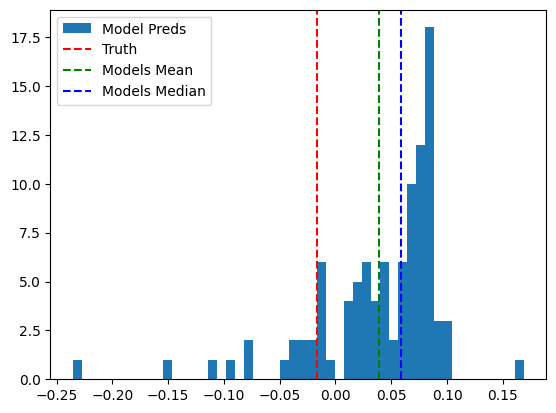

136
137
134 / 205
0.6536585365853659


In [53]:
idx = 17
array_2d = np.array(yhats)
i_entries = array_2d[:, idx]

plt.figure()
plt.hist(i_entries, bins=50,label='Model Preds')
plt.axvline(x=test_labels[idx],color='red',ls='--',label='Truth')
plt.axvline(x=np.mean(i_entries),color='green',ls='--',label='Models Mean')
plt.axvline(x=np.median(i_entries),color='blue',ls='--',label='Models Median')
plt.legend()
plt.show()
correct_sign = []
correct_sign2 = []
for i in range(normed_test_data.shape[0]):
    model_scores = array_2d[:, i]
    mean_score = np.mean(model_scores)
    med_score = np.median(model_scores)
    if np.sign(mean_score) == np.sign(test_labels[i]):
        correct_sign.append(1)
    if np.sign(med_score) == np.sign(test_labels[i]):
        correct_sign2.append(1)
    else:
        correct_sign.append(0)
        correct_sign2.append(0)
print(sum(correct_sign))
print(sum(correct_sign2))
print(sum(np.where(test_labels>0,1,0)),'/',len(test_labels))
print(sum(np.where(test_labels>0,1,0))/len(test_labels))


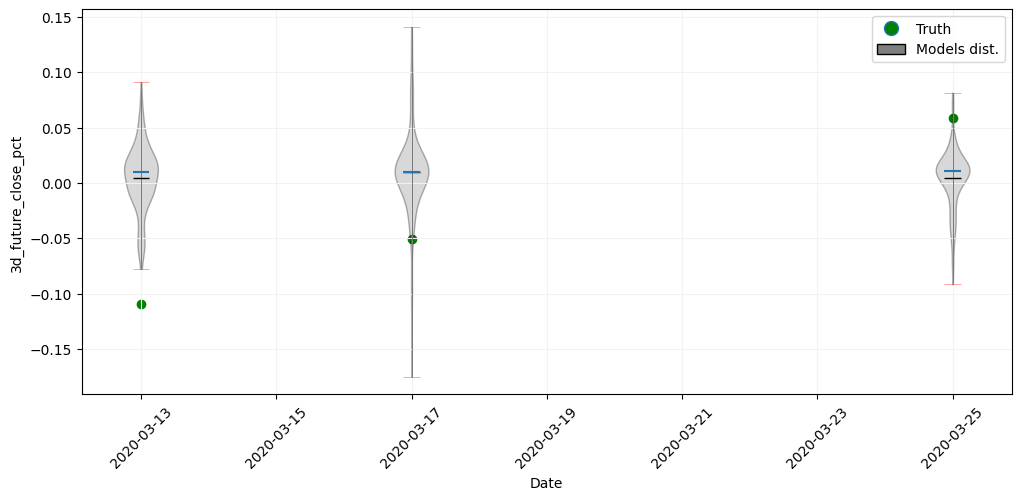

In [114]:
import matplotlib
fig, ax = plt.subplots(figsize=(12,5))
batch = 16
n_preds = 3
# print(df['5d_future_close_pct'].values[n_preds*batch:n_preds*(batch+1)])
# print('trut',test_labels.values[n_preds*batch:n_preds*(batch+1)])
# print('pred',test_predictions1[n_preds*batch:n_preds*(batch+1)])
# print('pmea',[np.mean(x) for x in yhats[n_preds*batch:n_preds*(batch+1)]])
ax.scatter(normed_test_data.index.values[n_preds*batch:n_preds*(batch+1)], test_labels.values[n_preds*batch:n_preds*(batch+1)],color='green',label='Truth')
# ax.scatter(normed_test_data.index.values[n_preds*batch:n_preds*(batch+1)], test_predictions1[n_preds*batch:n_preds*(batch+1)],marker='x',color='red',label='Model1')
# violin = ax.violinplot(yhats[5*batch:5*(batch+1)],positions=df.index.values[5*batch:5*(batch+1)],showmeans=True)
violin = ax.violinplot(yhats[n_preds*batch:n_preds*(batch+1)],positions=matplotlib.dates.date2num(normed_test_data.index)[n_preds*batch:n_preds*(batch+1)],showmeans=True,showmedians=True)
for pc in violin["bodies"]:
    pc.set_facecolor("grey")
    pc.set_edgecolor("black")
    pc.set_alpha(0.3)

violin['cbars'].set(ec='black',lw=0.5,alpha=0.7)
violin['cmins'].set(ec='red',lw=0.5,alpha=0.5)
violin['cmaxes'].set(ec='red',lw=0.5,alpha=0.5)
violin['cmeans'].set(ec='black',lw=1)
ax.tick_params(axis='x', rotation=45)
ax.set(xlabel='Date',ylabel='3d_future_close_pct')
ax.grid(color="0.95")
legend_elements = [matplotlib.lines.Line2D([0], [0], marker='o', label='Truth',markerfacecolor='g', markersize=10,linestyle='None'),
                #    matplotlib.lines.Line2D([0], [0], marker='x', color='red', label='Model1', markersize=10,linestyle='None'),
                   matplotlib.patches.Patch(facecolor='grey', edgecolor='k',label='Models dist.')]

ax.legend(handles=legend_elements,loc='best')
plt.show()

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', '1d_close_pct',
       '2d_close_pct', '3d_close_pct', '4d_close_pct', '5d_close_pct',
       '10d_close_pct', 'SMA20', 'EMA20', 'SMA50', 'EMA50', 'SMA100', 'EMA100',
       'RSI_14', 'RSI_100', 'VTXP_14', 'VTXM_14', 'STOCHk_14_26_3',
       'STOCHd_14_26_3', 'ADX_14', 'DMP_14', 'DMN_14', 'AMATe_LR_8_21_2',
       'AMATe_SR_8_21_2', 'AROOND_14', 'AROONU_14', 'AROONOSC_14',
       'PSARaf_0.02_0.2', 'PSARr_0.02_0.2', 'AO_5_34', 'UO_7_14_28', 'CG_10',
       'COPC_11_14_10', 'INERTIA_20_14', 'STC_10_12_26_0.5',
       'STCmacd_10_12_26_0.5', 'STCstoch_10_12_26_0.5'],
      dtype='object')
['2019-06-12T00:00:00.000000000' '2019-06-24T00:00:00.000000000'
 '2019-06-28T00:00:00.000000000' '2019-07-02T00:00:00.000000000'
 '2019-07-08T00:00:00.000000000']


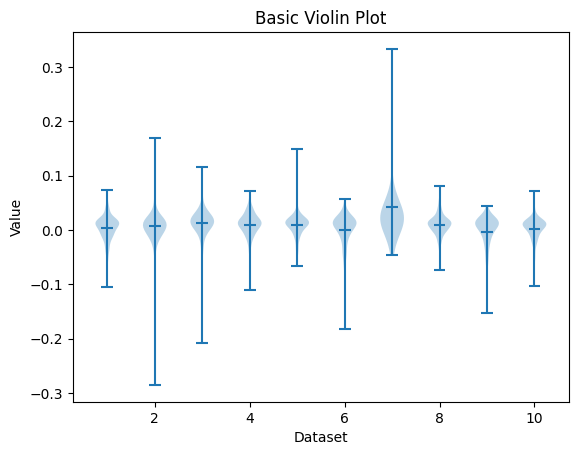

In [65]:
print(normed_test_data.columns)
# print(normed_test_data.head())
print(normed_test_data.index.values[:5])

# plt.violinplot(yhats[:5],positions=normed_test_data.index[:5],showmeans=True)
plt.violinplot(yhats[:10],showmeans=True)
plt.xlabel('Dataset')
plt.ylabel('Value')
plt.title('Basic Violin Plot')
plt.show()

In [ ]:
#https://www.tensorflow.org/probability/examples/STS_approximate_inference_for_models_with_non_Gaussian_observations

In [ ]:
model_nn = keras.Sequential([layers.Dense(128,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.1)),
                             layers.Dense(128,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.1)),
                             layers.Dense(64,activation='relu'),
                             layers.Dense(32,activation='relu'),
                             layers.Dense(1)])

# optimizer = tf.keras.optimizers.legacy.RMSprop(0.001)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
# optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.001,momentum=0.9)

model_nn.compile(loss=mse_penalty_term,#'mse',
                    optimizer=optimizer,
                    metrics=['mae', 'mse'])
model_nn.build(input_shape=normed_train_data.shape)
model_nn.summary()

In [ ]:
history_nn = model_nn.fit(normed_train_data, 
                          train_labels,
                          epochs=EPOCHS, 
                          validation_split = 0.3, 
                          verbose=0,)

In [ ]:
loss, mae, mse = model_nn.evaluate(normed_test_data, test_labels, verbose=2)
print("Testing set Mean Abs Error: {:5.2f}".format(mae))
train_predictions = model_nn.predict(normed_train_data).flatten()
test_predictions = model_nn.predict(normed_test_data).flatten()
plot_history(history_nn)

In [ ]:
a = plt.axes()
plt.scatter(train_labels, train_predictions,color='blue',label='train',alpha=.4)
plt.scatter(test_labels, test_predictions,color='orange',label='test',alpha=.7)
plt.plot(test_labels, test_labels,lw=4,color='cadetblue')
plt.plot(train_labels, train_labels,lw=2,color='cadetblue')
plt.axhline(y=0,ls='--',color='red')
plt.axvline(x=0,ls='--',color='red')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.legend()
# plt.savefig('ann-scatter.png')
plt.show()